Instalar dependencias

In [176]:
# import sys
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install contractions
# !{sys.executable} -m pip install Unidecode

#### Importar

In [177]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/douglasdeleon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/douglasdeleon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/douglasdeleon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/douglasdeleon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/douglasdeleon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Exploración

In [178]:
spam_assassin_dt = pd.read_csv("./completeSpamAssassin.csv")
enron_spam_dt = pd.read_csv("./enronSpamSubset.csv")

In [179]:
spam_assassin_dt.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [180]:
enron_spam_dt.head()

,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


Procederemos a remover las columnas que no nos son útiles para poder unir nuestros data sets

In [181]:
spam_assassin_dt = spam_assassin_dt.drop(["Unnamed: 0"], axis = 1)
enron_spam_dt = enron_spam_dt.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis = 1)
print("Columnas spam_assassin_dt: ", spam_assassin_dt.columns)
print("Columnas enron_spam_dt: ", enron_spam_dt.columns)

Columnas spam_assassin_dt:  Index(['Body', 'Label'], dtype='object')
Columnas enron_spam_dt:  Index(['Body', 'Label'], dtype='object')


Observamos nustros flags dentro de `Label` para ver si ambas cumplen de una manera binaria para ver si son spam o no

In [182]:
enron_spam_dt["Label"].unique()

array([1, 0])

In [183]:
spam_assassin_dt["Label"].unique()

array([1, 0])

### Ejemplos no SPAM

In [184]:
enron_spam_dt.loc[enron_spam_dt['Label'] == 1].head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [185]:
spam_assassin_dt.loc[spam_assassin_dt['Label'] == 1].head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


### Ejemplos  SPAM

In [186]:
enron_spam_dt.loc[enron_spam_dt['Label'] == 0].head()

,Body,Label
5000,Subject: re : legislative report ( 07 / 20 / 2...,0
5001,Subject: re : video conference with ross mcint...,0
5002,Subject: intern compensation\n sally :\n summe...,0
5003,Subject: jeff mcmahon named cfo\n today we ann...,0
5004,"Subject: re :\n frank ,\n yes .\n vince\n from...",0


In [187]:
spam_assassin_dt.loc[spam_assassin_dt['Label'] == 0].head()

,Body,Label
1896,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1897,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
1898,Man Threatens Explosion In Moscow Thursday Aug...,0
1899,Klez: The Virus That Won't Die\n \nAlready the...,0
1900,"> in adding cream to spaghetti carbonara, whi...",0


A simple vista si se diría que entre las filas con spam contienen una mayor cantidad de caracteres especiales y tienen un cuerpo diferente a las que no son spam.

In [188]:
df = enron_spam_dt.copy().append(spam_assassin_dt.copy())
print("Tamaño dataframe enron_spam_dt ", len(enron_spam_dt))
print("Tamaño datafbrame spam_assassin_dt ", len(spam_assassin_dt))
print("tamaño nuevo DF ", len(df))
df_safe = df.copy()
df_hist = df.copy()

Tamaño dataframe enron_spam_dt  10000
Tamaño datafbrame spam_assassin_dt  6046
tamaño nuevo DF  16046


In [189]:
# Mostrar diferencia en lenghts
df_hist["length"] = df_hist["Body"].apply(lambda x: len(str(x)))
df_hist["length"]

0        6210
1         898
2         779
3         543
4        1283
        ...  
6041        5
6042    16999
6043     7299
6044        5
6045        5
Name: length, Length: 16046, dtype: int64

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

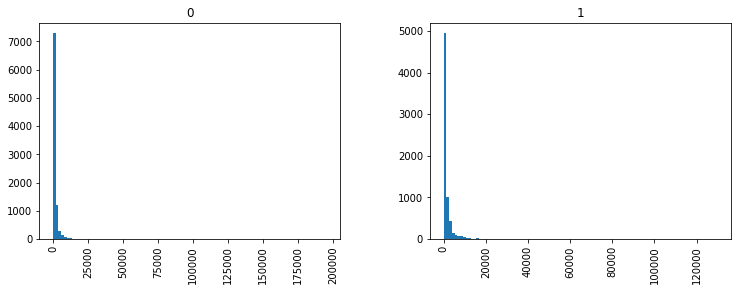

In [190]:
df_hist.hist(column = 'length', by ='Label',figsize=(12,4), bins = 100)

# Preprocesamiento

In [191]:
df['Body'].isnull().values.any()

True

In [192]:
df = df[df['Body'].notna()]

In [193]:
from string import punctuation
import unicodedata
import utils

In [194]:
# 0 SPAM example preproccessed
df.loc[df['Label'] == 0]["Body"].head(20).apply(utils.preprocess)

5000    subject legislative report independent energy ...
5001    subject video conference ross mcintyre nick ma...
5002    subject intern compensation sally summer analy...
5003    subject jeff mcmahon named cfo today announced...
5004    subject frank yes vince frank hayden enron enr...
5005    subject internship shane sorry vacation return...
5006    subject enron actuals march april estimated ac...
5007    subject chicago sally met jeff shankman hunter...
5008    subject control echelon interesting website th...
5009    subject eastrans nomination change effective p...
5010    subject follow voice mail discussed rick staff...
5011    subject flu shot flu shot continue available e...
5012    subject tiger team wharton participant lied li...
5013    subject organizational announcement pleased an...
5014    subject model forwarded kpeterso epec kpeterso...
5015    subject paso moved shoulder month september oc...
5016    subject non disclosure agreement p box livermo...
5017    subjec

In [195]:
# 1 HAM example vectorized
df.loc[df['Label'] == 1]["Body"].head(1000).apply(utils.preprocess)

0      subject stock promo mover cwtd urgent investor...
1      subject listed major search engine submitting ...
2      subject important information thu jun subject ...
3      subject utf q bask life utf q individual incre...
4      subject bidstogo place go thing hello privacy ...
                             ...                        
995    subject quick loan application hey would refln...
996    subject entrust visual identity u thinking bre...
997    subject specal offer wndows x p medium center ...
998    subject graphic design logo website corporate ...
999    subject impotence treatment hi new product off...
Name: Body, Length: 1000, dtype: object

In [211]:
len(df)

16045

## Modelo con BoW n = 1,2
Utilizamos CountVectorizer para rango de n bags 1 y 2

In [216]:
proccessed_body = df["Body"].apply(utils.preprocess)

proccessed_body

0       subject stock promo mover cwtd urgent investor...
1       subject listed major search engine submitting ...
2       subject important information thu jun subject ...
3       subject utf q bask life utf q individual incre...
4       subject bidstogo place go thing hello privacy ...
                              ...                        
6041                                                empty
6042    oneten insignificant matter heavily overemphas...
6043    issue reader write extension search dumb messa...
6044                                                empty
6045                                                empty
Name: Body, Length: 16045, dtype: object

In [217]:
len(df)

16045

In [218]:
# NBAG n = 1,2
vectorization_1_1 = CountVectorizer(min_df=0.05, max_df=1., ngram_range=(1,2))
vectorization_1_1_matrix = vectorization_1_1.fit_transform(proccessed_body)

In [219]:
vectorization_1_1_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [220]:
# Palabras únicas del corpus
vocabulario_1_1 = vectorization_1_1.get_feature_names()
# Mostrar el vector
pd.DataFrame(vectorization_1_1_matrix.toarray(), columns=vocabulario_1_1)

/Users/douglasdeleon/Documents/DouglasJr/UVG/semestre9/SecurityDS/lab-2-spam/spam-detect/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,access,account,address,already,also,another,around,attached,available,...,within,without,work,working,world,would,would like,wrote,www,year
0,0,0,0,0,0,0,0,0,0,0,...,5,0,1,1,19,1,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16041,1,0,0,2,1,4,1,0,0,2,...,0,1,1,2,4,0,0,0,0,0
16042,0,0,0,1,0,1,5,0,0,0,...,0,6,0,0,0,2,0,1,0,2
16043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(vectorization_1_1_matrix.toarray(), df["Label"], test_size=0.3, random_state=0)

In [222]:
mnb = MultinomialNB()
gnb = GaussianNB()
mnb_y_pred = mnb.fit(X_train, y_train).predict(X_test) # MultinomialNB
gnb_y_pred = gnb.fit(X_train, y_train).predict(X_test) # GaussianNB

In [223]:
# GaussianNB Results
utils.model_results(y_test, gnb_y_pred)


Matrix de confusión: 
 [[1526 1262]
 [  65 1961]]
              precision    recall  f1-score   support

       legit       0.96      0.55      0.70      2788
         dga       0.61      0.97      0.75      2026

    accuracy                           0.72      4814
   macro avg       0.78      0.76      0.72      4814
weighted avg       0.81      0.72      0.72      4814

recall_score:  [0.54734577 0.96791708]
precision_score:  [0.95914519 0.60843934]
f1_score:  [0.69696278 0.74718994]
accuracy:  0.7243456584960531


In [224]:
# MultinomialNB Results
utils.model_results(y_test, mnb_y_pred)

Matrix de confusión: 
 [[2449  339]
 [ 302 1724]]
              precision    recall  f1-score   support

       legit       0.89      0.88      0.88      2788
         dga       0.84      0.85      0.84      2026

    accuracy                           0.87      4814
   macro avg       0.86      0.86      0.86      4814
weighted avg       0.87      0.87      0.87      4814

recall_score:  [0.87840746 0.85093781]
precision_score:  [0.89022174 0.8356762 ]
f1_score:  [0.88427514 0.84323796]
accuracy:  0.866846697133361


## Modelo con TF-IDF

In [225]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0.05, max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(proccessed_body)
tv_matrix = tv_matrix.toarray()

vocabulario = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocabulario)


/Users/douglasdeleon/Documents/DouglasJr/UVG/semestre9/SecurityDS/lab-2-spam/spam-detect/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,access,account,address,already,also,another,around,attached,available,...,wish,within,without,work,working,world,would,wrote,www,year
0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.18,0.00,0.03,0.04,0.68,0.03,0.00,0.00,0.06
1,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.17,...,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00
3,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.39
4,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.27,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16040,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
16041,0.04,0.0,0.0,0.07,0.04,0.12,0.04,0.0,0.0,0.07,...,0.00,0.00,0.04,0.03,0.08,0.14,0.00,0.00,0.00,0.00
16042,0.00,0.0,0.0,0.04,0.00,0.04,0.26,0.0,0.0,0.00,...,0.00,0.00,0.29,0.00,0.00,0.00,0.07,0.05,0.00,0.08
16043,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [226]:
X_train, X_test, y_train, y_test = train_test_split(tv_matrix, df["Label"], test_size=0.3, random_state=0)

In [227]:
mnb = MultinomialNB()
gnb = GaussianNB()
mnb_y_pred = mnb.fit(X_train, y_train).predict(X_test) # MultinomialNB
gnb_y_pred = gnb.fit(X_train, y_train).predict(X_test) # GaussianNB

In [228]:
# GaussianNB results
utils.model_results(y_test, gnb_y_pred)

Matrix de confusión: 
 [[2437  351]
 [ 179 1847]]
              precision    recall  f1-score   support

       legit       0.93      0.87      0.90      2788
         dga       0.84      0.91      0.87      2026

    accuracy                           0.89      4814
   macro avg       0.89      0.89      0.89      4814
weighted avg       0.89      0.89      0.89      4814

recall_score:  [0.8741033  0.91164857]
precision_score:  [0.93157492 0.84030937]
f1_score:  [0.9019245  0.87452652]
accuracy:  0.8899044453676777


In [229]:
# MultinomialNB results
utils.model_results(y_test, mnb_y_pred)

Matrix de confusión: 
 [[2607  181]
 [ 341 1685]]
              precision    recall  f1-score   support

       legit       0.88      0.94      0.91      2788
         dga       0.90      0.83      0.87      2026

    accuracy                           0.89      4814
   macro avg       0.89      0.88      0.89      4814
weighted avg       0.89      0.89      0.89      4814

recall_score:  [0.93507891 0.83168806]
precision_score:  [0.88432836 0.90300107]
f1_score:  [0.90899582 0.86587873]
accuracy:  0.891566265060241


# Conclusión

La representación numérica con mejores resultados fue TF-IDF con un accuracy igual a 0.891 con un modelo Naive Bayes Multinomial, en comparación a BoW que obtuvo un accuracy igual a 0.967. Cabe resaltar que en ambos tipos de representación se obtuvo un mejor resultado con un modelo Naive Bayes Multinomial en comparación a Naive Bayes Gaussiano. Esto se vió reflejado con mayor fuerza en el modelo con la representación de BoW.